In [67]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

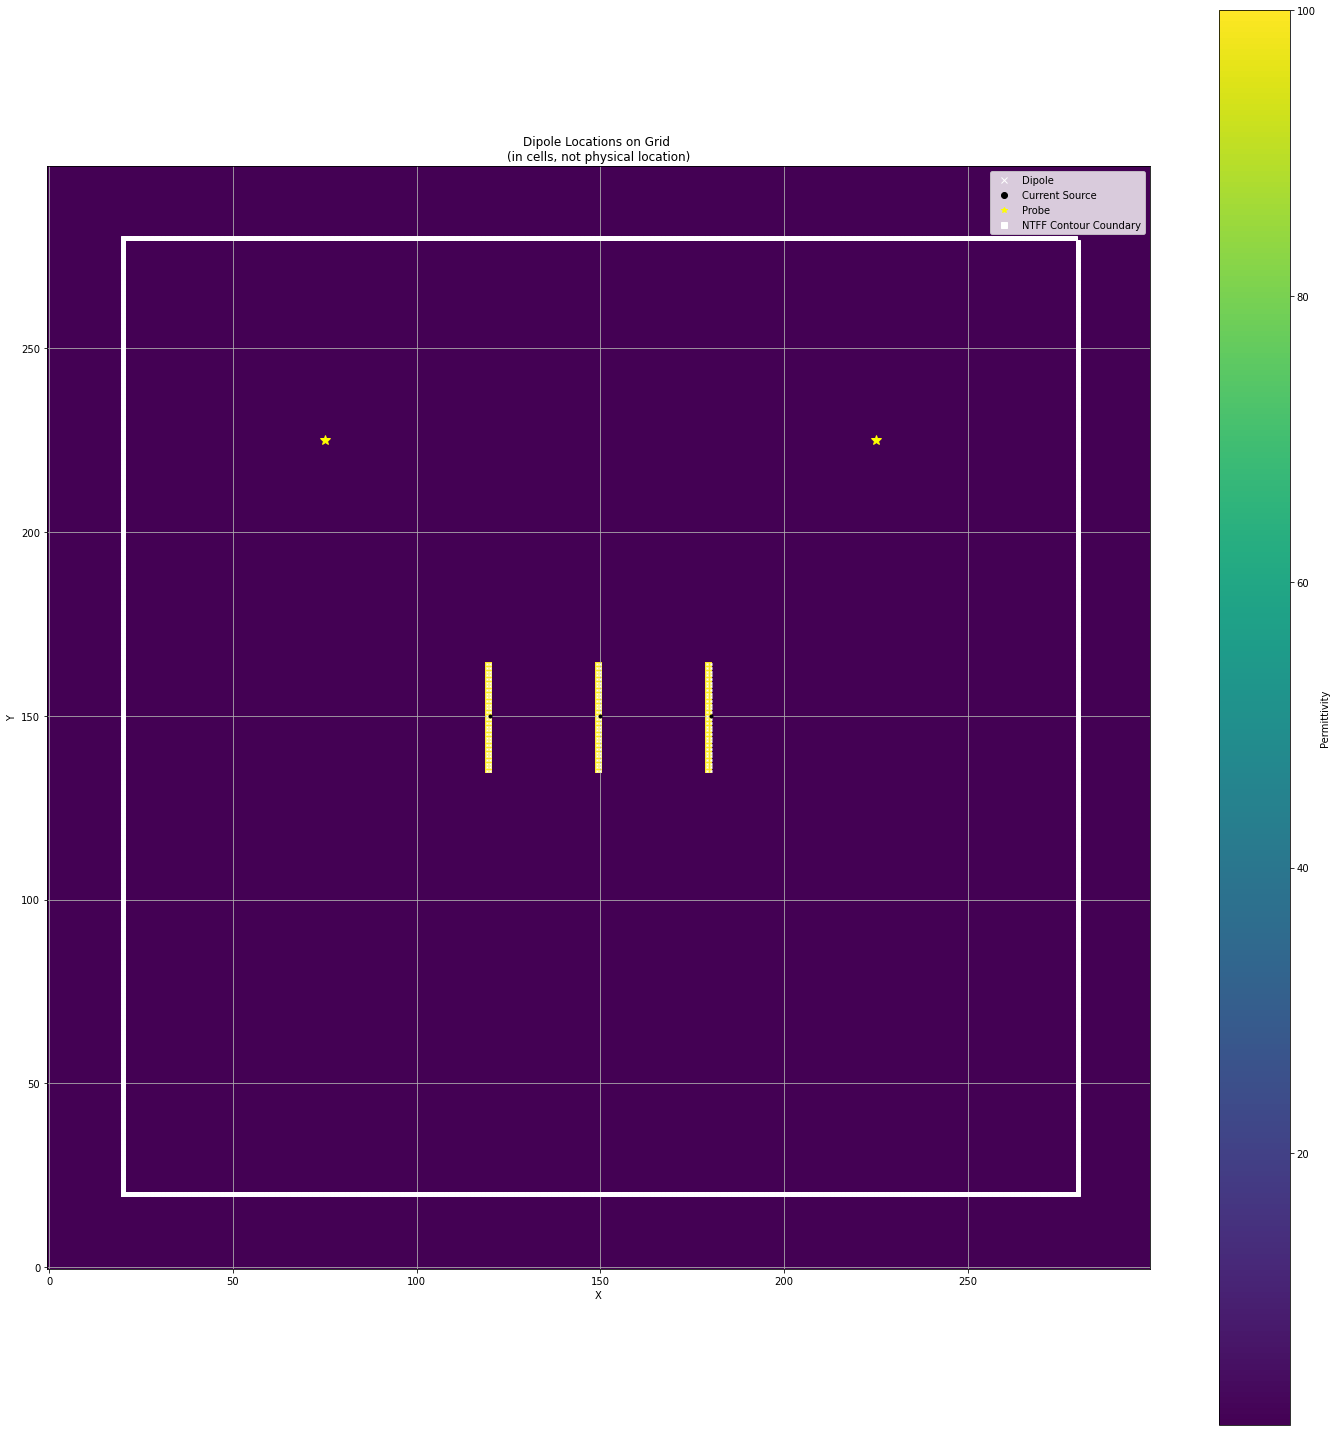

In [81]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1 #1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3 # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 520
f0 = 5e9

# Grid in cell units
whole_grid = 150e-3 # whole grid = 200 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2 # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
lambda0 = c0/f0 # wavelength for 5G is 6 cm
lambda_lower = 1.5e-10
lambda_upper = 2.5e-10
omega0 = 2 * np.pi * f0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

# Dipole Parameters
numberAntennas = 3
dipole_epsilon = 100
dipole_spacing_cells = int(15e-3 / dx) # space between dipoles = 15mm = 30 cells
dipole_width = 1e-3 # dipole thickness = 1 mm
dipole_height = 15e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.75) # this probe is put at the angle of target beam (45 degrees from x axis)
probe_beam_direction_y = int(numY_cells * .75)
probe_x = int(numX_cells * .25) # this probe is put far away from target angle (135 from x axis)
probe_y = int(numY_cells *.75)
Ez_probe_beam = np.zeros(max_time_steps) # store values at probes
Ez_probe = np.zeros(max_time_steps)

# NTFF Parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Compute phasor E and M fields on closed contour boundary
# defining square boundary form L1 --> L4
line_size = whole_grid - 20e-3 # lines form a boundary 10mm inside of whole grid size
numL_cells = int(line_size // dx) #numL cells is length of closed countour boundary in cell units

L_starting_dim= 10e-3 #starting index for L2, L4
L_starting_cell_idx = int(L_starting_dim //dx)
L_ending_dim= numX_cells - numL_cells
L_ending_cell_idx=L_starting_cell_idx + numL_cells

#L1 is vertical, RHS line
L1_col1 = np.full(numL_cells, L_ending_cell_idx)
L1_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)

L1_idxs = np.column_stack((L1_col1,L1_col2))

#L2 is vertical, LHS line
L2_col1=np.full(numL_cells,L_starting_cell_idx)
L2_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L2_idxs=np.column_stack((L2_col1,L2_col2))

#L3 is horizontal, top line
L3_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L3_col2=np.full(numL_cells, L_ending_cell_idx)
L3_idxs=np.column_stack((L3_col1,L3_col2))

#L4 is horizontal, bottom line
L4_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L4_col2=np.full(numL_cells, L_starting_cell_idx)
L4_idxs=np.column_stack((L4_col1,L4_col2))

#print(L1_idxs)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Current source vectors
sources = []

# Beam steering parameters
angle_target = 45
angle_target_rad = np.deg2rad(angle_target)
# k0 = 2 * np.pi / lambda0

# Store Ez Frames
Ez_frames = []

def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1: # for odd number of antennas, the middle one is at center of grid
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) *spacingBetween
            centers.append(leftPoint + (i*spacingBetween))

    else: # for an even number of antennas, the middle point of grid is between two antennas
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 -1) *spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i*spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    # Find dimensions of antenna on the grid
    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right + 1):
            for z in range(x_bottom, x_top + 1):
                grid[z, y] = e_dipole
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x, center_y))
    
    # Show where the sources are injected on grid
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')
    
    # Show where the probes are on the grid
    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 10, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 10, color = 'yellow')

    #Adding (x,y) pairs from L1, shown as white
    all_line_idx=[L1_idxs,L2_idxs,L3_idxs,L4_idxs]
    for j in all_line_idx:
        for x, y in j:
            plt.plot(x,y, 's',markersize = 4, color = 'white')
    
    # Plot the permittivity grid
    plt.imshow(grid, cmap='viridis', origin= 'lower')
    plt.colorbar(label='Permittivity')

    # Add the legend
    plt.plot([], [], 'x', color = 'white', label = 'Dipole')
    plt.plot([], [], 'o', color = 'black', label = 'Current Source')
    plt.plot([], [], '*', color = 'yellow', label = 'Probe')
    plt.plot([], [], 's', color ='white', label = 'NTFF Contour Coundary')
    plt.legend(loc='upper right', fontsize = 'medium')

    plt.title('Dipole Locations on Grid \n(in cells, not physical location)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.grid()
    plt.show()

placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)

In [82]:
for idx, (x_coord, y_coord) in enumerate(sources):
    phase = dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
    print(x_coord, y_coord, phase)

120 150 0.0
150 150 0.010606601717798213
180 150 0.021213203435596427


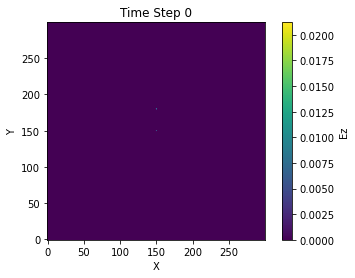

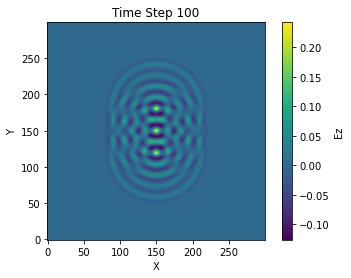

In [ ]:
# 2D FDTD Model

# Using absorbing boundary condition to simulate the energy being absorbed in air.
boundaryLeft = np.zeros(numY_cells)
boundaryRight = np.zeros(numY_cells)
boundaryBottom = np.zeros(numX_cells)
boundaryTop = np.zeros(numX_cells)


# Defining Ez_time_L1 (right hand side line)
Ez_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1 = np.zeros((numL_cells, max_time_steps))
Hy_time_L1 = np.zeros((numL_cells, max_time_steps))


# Main 2D FDTD Loop
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx

            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Hy_time_L1[idx,n] = (Ez[i,j] + Ez[i,j-1]) /2 # Collocate values on boundary

     # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy

            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Hx_time_L1[idx,n]= (Ez[i,j] + Ez[i-1, j]) /2 # Collocate values on boundary


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez ---------------------------------------------------------------------------- Wouldn't we have to update Ez_time_L1 using the Hx and Hy_time_l1 variables?
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)

            #recording Ez at L1
            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Ez_time_L1[idx,n]=Ez[i,j]

    # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

    # Apply excitation at antenna sources
    t_n = n * magic_time_step
    for idx, (x_coord, y_coord) in enumerate(sources):
        phase = dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
        # Ez[x_coord, y_coord] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n + phase)
        Ez[x_coord, y_coord] += np.sin(omega0 * t_n + phase)


    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 100 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 
        plt.show()
    
    # Create Ez animation using frames at every 10 time steps 
    if n % 10 == 0:
        Ez_frames.append(Ez.copy())


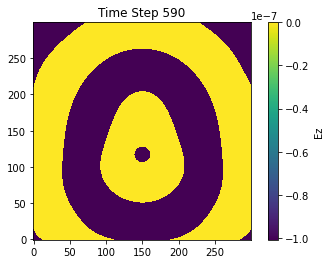

In [ ]:
# Create animation
from IPython.display import HTML  # Required to embed the animation
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(Ez_frames[0], cmap='viridis', origin='lower')
fig.colorbar(cax, label="Ez")
title = ax.set_title("")

def update(frame_idx):
    cax.set_array(Ez_frames[frame_idx])
    title.set_text(f"Time Step {frame_idx * 10}")
    return cax, title

ani = animation.FuncAnimation(fig, update, frames=len(Ez_frames), interval=100, blit=False)
HTML(ani.to_jshtml())


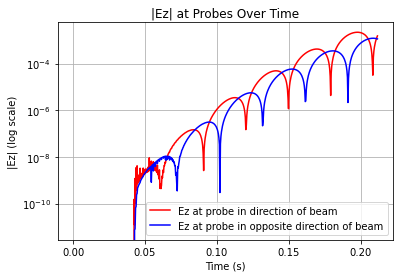

In [ ]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe in direction of beam', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe in opposite direction of beam', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.legend()
plt.grid(True)
plt.show()

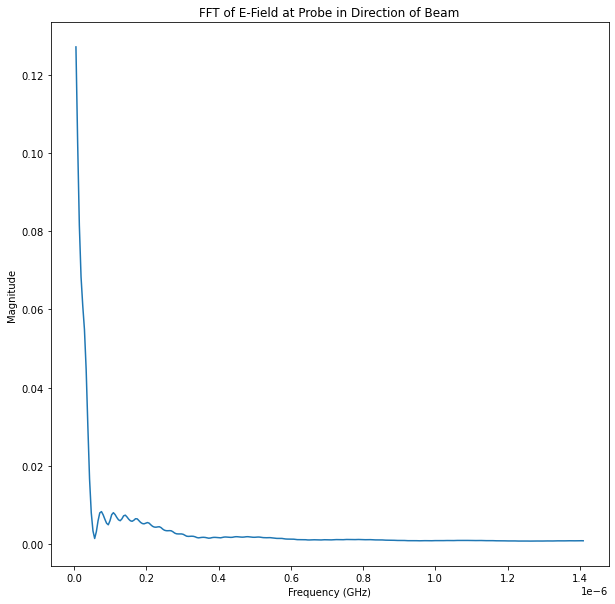

In [ ]:
Ez_main_fft = np.fft.fft(Ez_probe_beam)
freqs = np.fft.fftfreq(max_time_steps, d=magic_time_step)

positive_freqs = freqs[freqs>0]
fft_magnitude = np.abs(Ez_main_fft[freqs>0])

plt.figure(figsize = (10, 10))
plt.plot(positive_freqs , fft_magnitude)
plt.title('FFT of E-Field at Probe in Direction of Beam')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude')
plt.show()



In [ ]:
# Calculate gain difference between probes
power_off = np.sum(Ez_probe ** 2)
power_beam = np.sum(Ez_probe_beam ** 2)
gain_dB = 10 * np.log10(power_beam / power_off)
gain_dB # which means the probe at direction of beam had about 2.5 times increase in power

6.048166007737179

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000299,-0.000297,-0.000294,-0.000291,-0.000286,-0.000281,-0.000275,-0.000268,-0.000260,-0.000252
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000301,-0.000298,-0.000295,-0.000290,-0.000285,-0.000279,-0.000272,-0.000264,-0.000256,-0.000246
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000302,-0.000298,-0.000294,-0.000289,-0.000283,-0.000276,-0.000268,-0.000260,-0.000250,-0.000240
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000302,-0.000297,-0.000292,-0.000286,-0.000280,-0.000272,-0.000263,-0.000254,-0.000243,-0.000232
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000301,-0.000296,-0.000290,-0.000283,-0.000275,-0.000267,-0.000257,-0.000247,-0.000236,-0.000223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000310,-0.000306,-0.000300,-0.000295,-0.000288,-0.000280,-0.000272,-0.000262,-0.000252,-0.000240
256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000314,-0.000310,-0.000306,-0.000301,-0.000295,-0.000288,-0.000281,-0.000272,-0.000263,-0.000253
257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000316,-0.000314,-0.000311,-0.000306,-0.000302,-0.000296,-0.000289,-0.000282,-0.000273,-0.000264
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000319,-0.000317,-0.000314,-0.000311,-0.000307,-0.000302,-0.000297,-0.000290,-0.000283,-0.000274


c:\Users\Carrie Lei\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


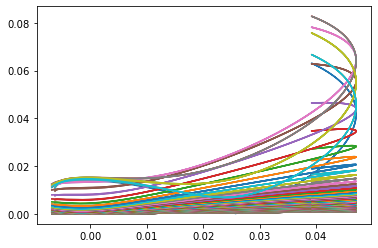

In [ ]:
# I'm not sure if we need this block anymore 

df_Ez_time_L1 = pd.DataFrame(Ez_time_L1)
display(df_Ez_time_L1)

frequencies = np.fft.fftfreq(max_time_steps, d=magic_time_step)
f0 = c0 / lambda0
target_idx = np.argmin(np.abs(frequencies - f0))

# Perform DFT on each row in Ez_time_L1 matrix
# Take fft of each spatial element into frequency domain
Ez_L1_fft_vals=np.fft.fft(Ez_time_L1, axis=1)
Ez_L1_freqs = Ez_L1_fft_vals[:, target_idx]

Hx_L1_fft_vals=np.fft.fft(Hx_time_L1, axis=1)
Hx_L1_freqs = Hx_L1_fft_vals[:, target_idx]

Hy_L1_fft_vals=np.fft.fft(Hy_time_L1, axis=1)
Hy_L1_freqs = Hy_L1_fft_vals[:, target_idx]

# Field spectra plot
# plt.figure()
# plt.plot(Ez_L1_freqs,np.abs(Ez_L1_fft_vals), label = 'Ez')
# plt.plot(Hx_L1_freqs,np.abs(Hx_L1_fft_vals), label = 'Hx')
# plt.plot(Hy_L1_freqs,np.abs(Hy_L1_fft_vals), label = 'Hy')
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.legend()
# plt.xlim([-100,100])
# plt.show()

In [46]:
# Compute Jeq (equivalent electric surface current) and Meq (equivalent magnetic surface current)
# Along L1, Meq = Ez(phasor)

# First: extract phasor element at 16.66 MHz
target_freq= omega0/(2*np.pi)
bin_idx = np.argmin(np.abs(Ez_L1_freqs - target_freq)) # which fft correspond to our target frequency

# Meq = n_hat x E
Meq_L1_phasors = Ez_L1_fft_vals[:,bin_idx] # get Ez phase at that frequency
Jeq_L1_phasors=Hy_L1_fft_vals[:,bin_idx] # get Hy phase at that frequency

# print(Meq_L1_phasors)
# print(Jeq_L1_phasors)
# THIS CODE WAS FOR COMPUTING FAR FIELD AT ONE POINT. 

[-1.         -0.99949987 -0.99899975 ...  0.99899975  0.99949987
  1.        ]
[ 0.45235244-0.28739612j  0.45951678-0.26542717j  0.46562497-0.24336174j
 ... -0.19695133-0.56360639j -0.17458391-0.57627519j
 -0.15149225-0.58803167j]


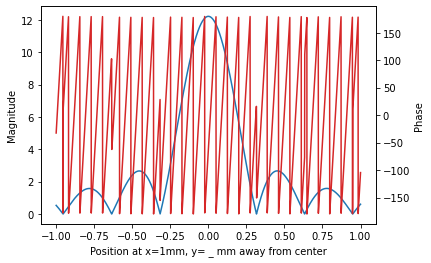

In [ ]:
# Above code deals with calcualting E in far field for only one point in space.
# To better visualize far field effects, need to evaluate Ez in far field across some line.

# Copying from existing code block, looping to create matrix of e^jkr hat r bar prime factors
# Defining r_bar position in far field: 

# This implementation is incorrect. First, we do not want to implement for some point r at some fixed distance, because we want to take distance to infinity.
# Therefore, calculate scattering width, which computes power radiated within a theta cross section should be plotted as a function of theta.

# Create an array of far field points to evaluate that are +1m in the x-direction and go from -1m to 1m in the y-direction. 
r_bar_x = 1000e-3 # x distance from center is 1000mm away: 1 m away
r_bar_y_min = -1000e-3
r_bar_y_max = 1000e-3
center_sim_x_y = np.array([center_x,center_y])

# Far field will be evaluated from, in x,y: 1m, -1m --> 1m, 1m: essentially vertical line to the right of simulation
num_ff_pts = int(abs((r_bar_y_max-r_bar_y_min)/dy)) # nunber of far field points is the lenght of vertical line divided by grid y size
r_bar_y_min_to_max_arr = np.linspace(r_bar_y_min, r_bar_y_max, num=num_ff_pts) # create an an array of a bunch of points on that line that correspond to yee grid sizes

Ez_far_field_arr=np.zeros(num_ff_pts,dtype=np.complex128)

for i in range (0,num_ff_pts):

    r_bar_x_y = np.array([r_bar_x, r_bar_y_min_to_max_arr[i]])

    r_hat_dot_r_prime_bar = np.zeros(numL_cells)
    
    #calculate magnitude using built in function
    r_bar_magnitude= np.linalg.norm(r_bar_x_y - center_sim_x_y)
    #print(r_bar_magnitude)
    
    #define unit vector r hat from given r bar positions
    r_hat_x_y = np.array([r_bar_x/r_bar_magnitude, r_bar_y_min_to_max_arr[i]/r_bar_magnitude])

    #near field source point vector
    #as of now: only from pts on L1
    r_bar_prime_x=(np.linspace(L_ending_dim,L_ending_dim,numL_cells)) - (center_x*dx)
    r_bar_prime_y=(np.linspace(L_starting_dim,L_ending_dim,numL_cells)) - (center_y*dy)
    r_bar_prime_x_y=np.array([r_bar_prime_x,r_bar_prime_y])

    #element wise dot product from single rbarprime vector (to ff point), and r_hat_x_y points (all points along L1)
    r_hat_dot_r_prime_bar=np.dot(r_hat_x_y,r_bar_prime_x_y)
    #print(r_hat_dot_r_prime_bar)                    

    k = 2 * np.pi / lambda0
    L1_integral = 0+0j
    L1_integral_arr = ( (omega0 * mu0 * np.sum(Jeq_L1_phasors[0:-1])) - (k*Meq_L1_phasors[0:-1]) ) *np.exp(1j * k *r_hat_dot_r_prime_bar[0:-1])

    L1_integral_val=np.sum(L1_integral_arr)

    r=r_bar_magnitude
    far_field_integral_const= (np.exp(-1j*k*r) / math.sqrt(r) ) * ( (np.exp(np.pi * 1j / 4)) / math.sqrt(8*np.pi*k) )

    Ez_far_field_arr[i] = far_field_integral_const * L1_integral_val

print(r_bar_y_min_to_max_arr)
print(Ez_far_field_arr)

#visualizing Ez_far_field_arr
mag=np.abs(Ez_far_field_arr)
phase=np.angle(Ez_far_field_arr)
phase_deg=180*phase/np.pi

fig,ax1=plt.subplots()
ax1.set_xlabel('Position at x=1m, y= _ mm away from center')
ax1.set_ylabel('Magnitude')
color='tab:blue'
ax1.plot(r_bar_y_min_to_max_arr,mag,color=color)

# ax2=ax1.twinx()
# ax2.set_ylabel('Phase')
# color='tab:red'
# ax2.plot(r_bar_y_min_to_max_arr,phase_deg,color=color)
plt.show()  

In [48]:
#Computing r' cos (phi) for e^jkr'cosphi component

#Given input parameter phi
#Defining r_prime_cos_phi_vec
r_prime_cos_phi_vec=[]
r_prime_vec=[]
phi_vector=[]

theta_deg = 30 #sample theta val in deg
theta_rad=math.radians(theta_deg)
r_mag=((L_ending_cell_idx-center_x)*dx) / math.cos(theta_rad)
for x, y in L1_idxs:
    x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
    r_prime_mag=np.linalg.norm(x_y_distances)
    
    theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
    theta_prime_deg=math.degrees(theta_prime_rad)
    phi=theta_deg-theta_prime_deg

    phi_rad=math.radians(phi)
    phi_vector.append(phi)

    phase_const= r_mag * math.cos(phi_rad)
    #print(phi_rad)
    # print(r_mag * math.cos(phi_rad))
    r_prime_cos_phi_vec.append(phase_const)

# print(phi_vector)
r_prime_cos_phi_vec=np.array(r_prime_cos_phi_vec)
# print(r_prime_cos_phi_vec)

idx_max = np.argmax(np.abs(Ez_far_field_arr))
idx_max

2000

In [49]:
#computing closed contour integral over L1 of Jeq and Meq
#defining wavenumber k
k = 2 * np.pi / lambda0
L1_integral = 0+0j
L1_integral_arr = ( (omega0 * mu0 * np.sum(Jeq_L1_phasors[0:-1])) - (k*Meq_L1_phasors[0:-1]) ) * np.exp(1j * k *r_prime_cos_phi_vec[0:-1])

L1_integral_val=np.sum(L1_integral_arr)

L1_integral_val_squared=L1_integral_val**2

E_initial_amplitude=1
lambda_val=lambda0
sigma_2d=(lambda_val / (8*np.pi*(E_initial_amplitude**2))) * L1_integral_val_squared
print(sigma_2d)
#print(L1_integral_arr)
#print(L1_integral_val)

(21942.40231994426+14343.63680992311j)


C:\Users\Carrie Lei\AppData\Local\Temp\ipykernel_14648\267325407.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_2d[int(theta)]=sigma_2d_val


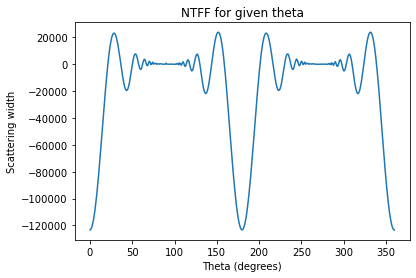

In [50]:
# Code to look at scattering width

#Looping through multiple theta input parameters
theta_input_param=np.linspace(0,360,361)
#print(theta_input_param)
r_prime_cos_phi_vec=[]
sigma_2d=np.zeros(361)
k = 2 * np.pi / lambda0
for theta in theta_input_param:
    theta_deg = theta
    theta_rad=math.radians(theta_deg)
    r_mag=((L_ending_cell_idx-center_x)*dx) / math.cos(theta_rad)
    r_prime_cos_phi_vec=[]
    for x, y in L1_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=np.linalg.norm(x_y_distances)
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=theta_deg-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector.append(phi)

        phase_const= r_mag * math.cos(phi_rad)
        r_prime_cos_phi_vec.append(phase_const)


    r_prime_cos_phi_vec=np.array(r_prime_cos_phi_vec)
    L1_integral = 0+0j
    L1_integral_arr = ( (omega0 * mu0 * np.sum(Jeq_L1_phasors[0:-1])) - (k*Meq_L1_phasors[0:-1]) ) * np.exp(1j * k *r_prime_cos_phi_vec[0:-1])

    L1_integral_val=np.sum(L1_integral_arr)
    L1_integral_val_squared=L1_integral_val**2

    E_initial_amplitude=1
    lambda_val=lambda0
    sigma_2d_val=(lambda_val / (8*np.pi*(E_initial_amplitude**2))) * L1_integral_val_squared
    sigma_2d[int(theta)]=sigma_2d_val

plt.figure()
plt.plot(theta_input_param, sigma_2d)
plt.xlabel('Theta (degrees)')
plt.ylabel('Scattering width')
plt.title('NTFF for given theta')
plt.show()

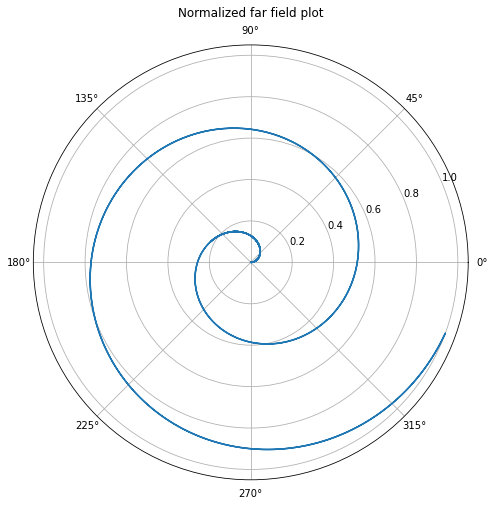

In [52]:
# Polar plot
# thetas = np.linspace(-90, 90, numY_cells)
theta_rad = np.abs(Ez_far_field_arr) # theta already in degrees
r_normalized = np.abs(Ez_far_field_arr)/np.max(np.abs(Ez_far_field_arr))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.plot(theta_rad, r_normalized)
# ax.set_theta_zero_location('right')  # 0 degrees points to the right
# ax.set_theta_direction(-1)           # Clockwise
ax.set_title('Normalized far field plot', va='bottom')
plt.show()

In [18]:
# del Ez_time_L1
# del Hx_time_L1
# del Hy_time_L1
# del Ez_L1_fft_vals
# del Hx_L1_fft_vals
# del Hy_L1_fft_vals